In [2]:
import tensorflow as tf
from Dive_into_deep_learning.d2l import tensorflow as d2l

2023-08-18 15:47:02.607072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def masked_softmax(X, valid_lens):
    """
    Perform softmax operation by masking elemets on the last axis.
    :param X: 3D tensor
    :param valid_lens: 1D or 2D tensor
    :return:
    """
    def _sequence_mask(X, valid_len, value=0):
        # X shape: (将前两维合并, 数据维度d) => (len(valid_len), maxlen)
        maxlen = X.shape[1] # 数据维度d
        # (None, maxlen) < (len(valid_len), None) => (len(valid_len), maxlen)
        mask = tf.range(0, maxlen, dtype=tf.float32)[None, :] < tf.cast(valid_len[:, None], dtype=tf.float32)
        return tf.where(mask, X, value)
    
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, shape[1])
        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        X = _sequence_mask(tf.reshape(X, shape=(-1, shape[-1])), valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

masked_softmax(tf.random.uniform(shape=(2, 2, 4)), tf.constant([2, 3]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[0.44153243, 0.5584676 , 0.        , 0.        ],
        [0.40336692, 0.596633  , 0.        , 0.        ]],

       [[0.25869885, 0.49383464, 0.24746649, 0.        ],
        [0.33935153, 0.41612616, 0.24452233, 0.        ]]], dtype=float32)>

In [5]:
masked_softmax(tf.random.uniform((2, 2, 4)), tf.constant([[1, 3], [2, 4]]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[1.        , 0.        , 0.        , 0.        ],
        [0.29369542, 0.4070721 , 0.29923242, 0.        ]],

       [[0.56352246, 0.43647757, 0.        , 0.        ],
        [0.19519034, 0.2987571 , 0.36306342, 0.14298914]]], dtype=float32)>

In [6]:
Q = tf.ones((2, 3, 4))
K = tf.ones((2, 4, 6))
Q @ K
# d2l.check_shape(tf.matmul(Q, K).numpy(), (2, 3, 6))

<tf.Tensor: shape=(2, 3, 6), dtype=float32, numpy=
array([[[4., 4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4., 4.]],

       [[4., 4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4., 4.]]], dtype=float32)>

# 1. Scaled Dot Product Attention

In [7]:
class DotProductAttention(tf.keras.layers.Layer):
    """Scaled dot product attention"""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, queries, keys, values, valid_lens=None, **kwargs):
        d = queries.shape[-1]
        scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(d, dtype=tf.float32))
        self.attention_weights = masked_softmax(scores, valid_lens)
        # (batch_size, no. of queries, no. of keys) @ (batch_size, no. of keys, value dimension)
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values)

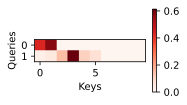

In [9]:
queries = tf.random.normal(shape=(2, 1, 2))
keys = tf.random.normal(shape=(2, 10, 2))
values = tf.random.normal(shape=(2, 10, 4))
valid_lens = tf.constant([2, 6])

attention = DotProductAttention(dropout=0.5)
d2l.check_shape(attention(queries, keys, values, valid_lens, training=False),
                (2, 1, 4))

d2l.show_heatmaps(tf.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [10]:
attention.attention_weights

<tf.Tensor: shape=(2, 1, 10), dtype=float32, numpy=
array([[[0.4290673 , 0.5709327 , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.01749818, 0.04505935, 0.14705227, 0.6125946 , 0.10683904,
         0.07095651, 0.        , 0.        , 0.        , 0.        ]]],
      dtype=float32)>

# 2. Additive Attention

In [11]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.W_q = tf.keras.layers.Dense(num_hiddens, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, queries, keys, values, valid_lens, **kwargs):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # (batch_size, no. of queries, 1, num_hiddens) + (batch_size, 1, no. of keys, num_hiddens)
        features = tf.expand_dims(queries, 2) + tf.expand_dims(keys, 1)
        features = tf.nn.tanh(features)
        # (batch_size, no. of queries, no. of keys)
        scores = tf.squeeze(self.W_v(features), axis=-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # return (batch_size, no. of queries, value dimension)
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values)

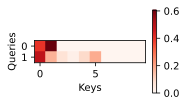

In [12]:
queries = tf.random.normal(shape=(2, 1, 20))

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
d2l.check_shape(attention(queries, keys, values, valid_lens, training=False),
                (2, 1, 4))

d2l.show_heatmaps(tf.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')